# Lecture 04: Optimization

Objective: implement numerical optimization algorithms for maximum likelihood estimation.

In [1]:
import numpy as np, matplotlib.pyplot as plt
import polars as pl
from sklearn.linear_model import Ridge
from scipy.special import beta

# Load data

Loading and simple cleanup.

In [2]:
df = (
    pl.read_csv("https://github.com/Michael-tehc/MachineLearning-MSU/raw/refs/heads/main/data/Housing.csv")
    .with_columns(
        pl.Series('dprice', list(np.random.binomial(1, 0.05, 545) * 2e7))
    )
    .with_columns(
        price=pl.col('price') + pl.col('dprice')
    )
)
df

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,dprice
f64,i64,i64,i64,i64,str,str,str,str,str,i64,str,str,f64
1.33e7,7420,4,2,3,"""yes""","""no""","""no""","""no""","""yes""",2,"""yes""","""furnished""",0.0
1.225e7,8960,4,4,4,"""yes""","""no""","""no""","""no""","""yes""",3,"""no""","""furnished""",0.0
1.225e7,9960,3,2,2,"""yes""","""no""","""yes""","""no""","""no""",2,"""yes""","""semi-furnished""",0.0
1.2215e7,7500,4,2,2,"""yes""","""no""","""yes""","""no""","""yes""",3,"""yes""","""furnished""",0.0
1.141e7,7420,4,1,2,"""yes""","""yes""","""yes""","""no""","""yes""",2,"""no""","""furnished""",0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.82e6,3000,2,1,1,"""yes""","""no""","""yes""","""no""","""no""",2,"""no""","""unfurnished""",0.0
1.76715e6,2400,3,1,1,"""no""","""no""","""no""","""no""","""no""",0,"""no""","""semi-furnished""",0.0
1.75e6,3620,2,1,1,"""yes""","""no""","""no""","""no""","""no""",0,"""no""","""unfurnished""",0.0


In [3]:
# Transform `yes/no` values to 1/0
df_clean = df.with_columns(
    pl.col('price', 'area').log(),
    pl.col(
        "mainroad guestroom basement hotwaterheating airconditioning prefarea".split()
    ).replace_strict({'yes': True, 'no': False})
)
df_clean

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,dprice
f64,f64,i64,i64,i64,bool,bool,bool,bool,bool,i64,bool,str,f64
16.403275,8.911934,4,2,3,true,false,false,false,true,2,true,"""furnished""",0.0
16.321036,9.100526,4,4,4,true,false,false,false,true,3,false,"""furnished""",0.0
16.321036,9.206332,3,2,2,true,false,true,false,false,2,true,"""semi-furnished""",0.0
16.318175,8.922658,4,2,2,true,false,true,false,true,3,true,"""furnished""",0.0
16.250001,8.911934,4,1,2,true,true,true,false,true,2,false,"""furnished""",0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
14.414347,8.006368,2,1,1,true,false,true,false,false,2,false,"""unfurnished""",0.0
14.384879,7.783224,3,1,1,false,false,false,false,false,0,false,"""semi-furnished""",0.0
14.375126,8.194229,2,1,1,true,false,false,false,false,0,false,"""unfurnished""",0.0


In [4]:
FEATURE_NAMES = ['area', 'bedrooms', 'bathrooms', 'mainroad', 'basement']
X = df_clean.select(FEATURE_NAMES).to_numpy()
y = df_clean['price'].to_numpy()
X.shape, y.shape

((545, 5), (545,))

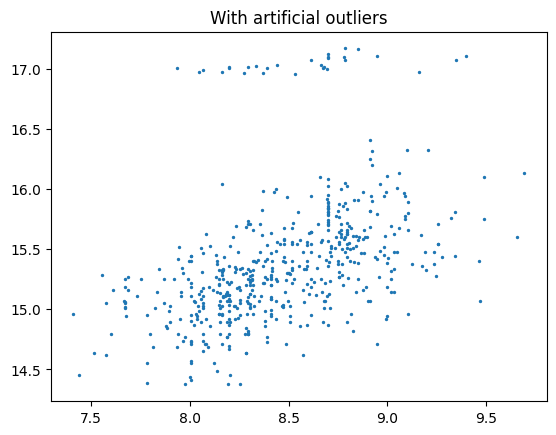

In [5]:
plt.scatter(X[:, 0], y, s=2); plt.title('With artificial outliers');

# Simple linear model: Gaussian noise + Ridge regularization

Use [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

In [6]:
def aic(loglik: float, nparams: int, N: int=None) -> float:
    return -2 * loglik + 2 * nparams

def bic(loglik: float, nparams: int, N: int) -> float:
    return -2 * loglik + np.log(N) * nparams

In [7]:
def logpdf_Gauss(x, mu, sigma):
    z = (x - mu) / sigma
    return -np.log(sigma) - np.log(2 * np.pi)/2 - z**2 / 2
def pdf_Gauss(x, mu, sigma):
    return np.exp(logpdf_Gauss(x, mu, sigma))

def loglik_Gauss(params: np.ndarray, X, y):
    params = np.array(params)
    N, F = X.shape
    b, w, sigma = params[0], params[1:F+1], params[-1]

    locations = b + X @ w
    return logpdf_Gauss(y, locations, sigma).sum()

In [8]:
class RidgeGauss:
    def __init__(self, lmb: float, feat_names: list[str]):
        assert lmb >= 0
        self.lmb, self.feature_names = lmb, feat_names

    @property
    def params_df(self) -> pl.DataFrame: return pl.DataFrame({
        'name': ['bias', *self.feature_names, 'scale', 'nu'],
        'value': [self.intercept_, *self.coef_, self.scale_, np.inf]
    })

    def __repr__(self):
        with pl.Config(tbl_hide_column_data_types=True):
            AIC, BIC = self.aic_, self.bic_
            return (
                f"{self.__class__.__name__}({self.lmb}) ({AIC=:.3f}, {BIC=:.3f}):\n"
                f"{self.params_df}"
            )

    def fit(self, X, y):
        N = len(y)
        model = Ridge(self.lmb).fit(X, y)
        residuals_scaled = y - model.intercept_ - X @ model.coef_

        self.scale_ = np.sqrt(np.linalg.norm(residuals_scaled)**2 / N)
        self.intercept_ = model.intercept_
        self.coef_ = model.coef_
        self.residuals_ = residuals_scaled / self.scale_

        params = [self.intercept_, *self.coef_, self.scale_]
        self.aic_ = aic(loglik_Gauss(params, X, y), len(params))
        self.bic_ = bic(loglik_Gauss(params, X, y), len(params), N)
        return self

In [9]:
model_Gauss = RidgeGauss(10, FEATURE_NAMES).fit(X, y)
model_Gauss

RidgeGauss(10) (AIC=699.814, BIC=729.920):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 11.246463 │
│ area      ┆ 0.412755  │
│ bedrooms  ┆ 0.06782   │
│ bathrooms ┆ 0.212464  │
│ mainroad  ┆ 0.164285  │
│ basement  ┆ 0.106734  │
│ scale     ┆ 0.453958  │
│ nu        ┆ inf       │
└───────────┴───────────┘

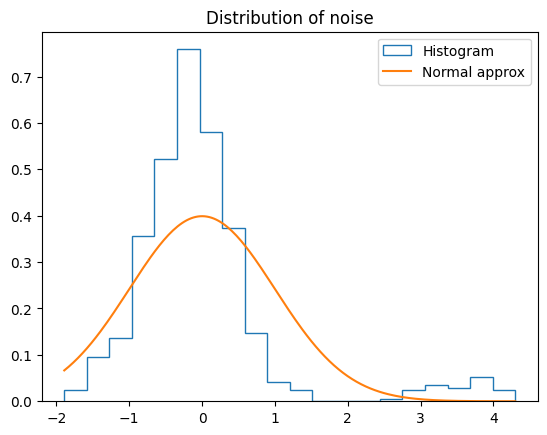

In [10]:
noise = model_Gauss.residuals_

possible_noises = np.linspace(noise.min(), noise.max(), 200)
plt.hist(noise, bins=20, histtype='step', density=True, label="Histogram")
plt.plot(possible_noises, pdf_Gauss(possible_noises, 0, 1), label="Normal approx")
plt.legend()
plt.title("Distribution of noise");

# Loss for Student t noise

Semi-Bayesian formulation:
$$
\begin{aligned}
w &\sim \mathcal N\left( 0, \frac{1}{\lambda} I \right)\\
y_n &= b + x_n^\top w + \sigma \varepsilon_n, \quad \varepsilon_n \sim \mathrm{Student}(\nu)
\end{aligned}
$$

__NOTE__: $\nu > 0$ is now a _parameter_ of the model!!

## Student t PDF

$$
p(t; \nu) = \frac1{\sqrt{\nu} B(1/2, \nu/2)} \left(
1 + \frac{1}{\nu}t^2
\right)^{-(\nu+1)/2}, \quad t\in\mathbb R
$$

Location-scale version:
$$
p(x; \mu, \sigma, \nu) = \frac1\sigma \frac1{\sqrt{\nu} B(1/2, \nu/2)} \left(
1 + \frac{1}{\nu} \left( \frac{x - \mu}{\sigma} \right)^2
\right)^{-(\nu+1)/2}, \quad x\in\mathbb R
$$

## Negative log-likelihood for single pair $(x_n, y_n)$

- Location parameter: $\mu_n = b + w^\top x_n$.
- Scale parameter: $\sigma$.

$$
-\ln p(y_n | x_n, b,w,\sigma,\nu) =
\ln\sigma + \frac{\ln\nu}{2} +
\ln B\left( \frac{\nu}2, \frac12 \right) -
\frac{1+\nu}2 \left[
\ln\nu - \ln\left(
 \nu + \frac{(y_n - b - x_n^\top w)^2}{\sigma^2}
\right)
\right],
$$
where $B\left( \frac{\nu}2, \frac12 \right)$ is the [Beta function](https://en.wikipedia.org/wiki/Beta_function).

The negative log-likelihood for the full dataset is a sum, as usual:
$$
\hat b, \hat w, \hat\sigma, \hat\nu = \arg\min -\sum_{n=1}^N \ln \left[
 \frac{1}{\sigma} p\left(
     \frac{y_n - b - x_n^\top w}{\sigma}; \nu
 \right)
\right] + \lambda \frac12 \lVert w \rVert^2
$$

__NOTE:__ $\sigma>0$ and $\nu > 0$, we must take this into account!

In [11]:
def logpdf_Student(x, mu, sigma, nu):
    x = np.array(x)
    t = (x - mu)/sigma
    return (
        -np.log(sigma) - np.log(nu) / 2 - np.log(beta(1/2, nu/2))
        -(nu+1)/2 * np.log(1 + t**2 / nu)
    )

def pdf_Student(x, mu, sigma, nu):
    return np.exp(logpdf_Student(x, mu, sigma, nu))

In [12]:
def loglik_Student(params: np.ndarray, X, y):
    params = np.array(params)
    N, F = X.shape
    b, w, sigma, nu = params[0], params[1:F+1], params[F+1], params[-1]
    if (sigma <= 0) or (nu <= 0):
        return -np.inf # Constraints are violated!!

    location = b + X @ w
    return logpdf_Student(y, location, sigma, nu).sum()

def nll_Student_penalized(params: np.ndarray, X, y, lmb=0):
    "Estimates -E(log p(y_n | x_n, params))"
    params = np.array(params)
    N, F = X.shape
    b, w, sigma, nu = params[0], params[1:F+1], params[F+1], params[-1]
    nll = -loglik_Student(params, X, y) + lmb/2 * np.linalg.norm(w)**2
    return nll / N

In [13]:
X.shape

(545, 5)

In [14]:
loglik_Student(
    [
        1, # bias
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ], X, y
)

np.float64(-2321.6513643700346)

In [15]:
# Nudge one of the parameters to increase log-likelihood
loglik_Student(
    [
        y.mean(), # bias
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ],
    X, y
)

np.float64(-1757.1924043276626)

In [16]:
# This is log-likelihood divided by number of samples N
nll_Student_penalized(
    [
        1, # bias
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ], X, y
)

np.float64(4.25991076031199)

In [17]:
# Nudge one of the parameters to decrease negative log-likelihood
nll_Student_penalized(
    [
        y.mean(), # bias
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ], X, y
)

np.float64(3.2242062464727756)

# Minimization by checking all values

Want to find $\theta^* = \arg\min_\theta f(\theta)$.

1. List all values of $\theta$ we want to check: $(\theta_1,\theta_2,\dots,\theta_K)$.
2. Choose index with lowest value of $f$: $$k^* = \arg\min_{k\in 1\dots K} f(\theta_k)$$
3. The corresponding $\theta_{k^*}$ is our answer.

bias_best=np.float64(15.29291692823201)
loss_best=np.float64(3.224257504042215)


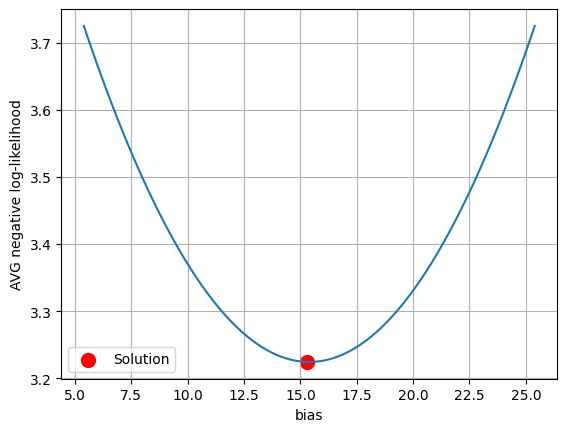

In [18]:
# Minimize wrt bias
nll = lambda bias: nll_Student_penalized(
    [
        bias,
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ], X, y
)
# Possible biases to check
biases = np.linspace(y.mean() - 10, y.mean() + 10, 100)
losses = np.vectorize(nll)(biases) # Corresponding losses

# Index of lowest loss
solution_index = np.argmin(losses)
loss_best, bias_best = losses[solution_index], biases[solution_index]
print(f"{bias_best=}\n{loss_best=}")
plt.plot(biases, losses)
plt.scatter([bias_best], [loss_best], s=100, c='red', label="Solution")
plt.legend()
plt.xlabel('bias'); plt.ylabel('AVG negative log-likelihood'); plt.grid();

w2_best=np.float64(0.10010010010010717)
loss_best=np.float64(3.2243417614289864)


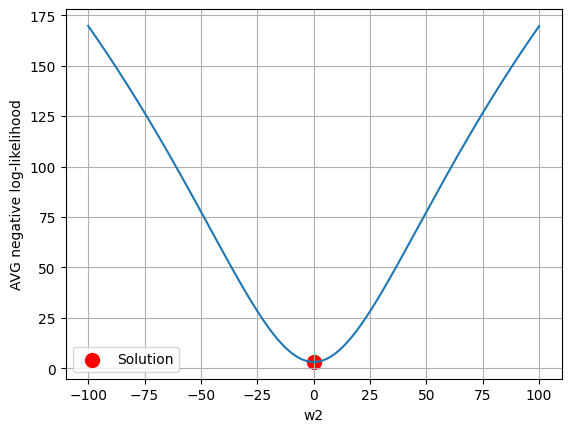

In [19]:
# Minimize wrt 1st weight
nll = lambda w2: nll_Student_penalized(
    [
        15.295396272411692, # best bias from above
        0,w2,0,0,0, # weights
        10, # scale
        200, # nu
    ], X, y
)
# Possible values of `w1` to check
w2s = np.linspace(-100, 100, 1000)
losses = np.vectorize(nll)(w2s)

# Index of lowest loss
solution_index = np.argmin(losses)
loss_best, w2_best = losses[solution_index], w2s[solution_index]
print(f"{w2_best=}\n{loss_best=}")
plt.plot(w2s, losses)
plt.scatter([w2_best], [loss_best], s=100, c='red', label="Solution")
plt.legend()
plt.xlabel('w2'); plt.ylabel('AVG negative log-likelihood'); plt.grid();

In [20]:
# Helper function
def numpy_replace(arr: np.ndarray, index: int, value: float):
    arr = np.array(arr).copy()
    arr[index] = value
    return arr

In [21]:
x_original = np.array([0,1,2,3])
print("Replace element 0:", numpy_replace([0,1,2], 0, -100))
print("Replace element 1:", numpy_replace([0,1,2], 1, -512))
print("Original         :", x_original)

Replace element 0: [-100    1    2]
Replace element 1: [   0 -512    2]
Original         : [0 1 2 3]


In [22]:
np.arange(-2, 2, 0.1)

array([-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        1.77635684e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
        1.20000000e+00,  1.30000000e+00,  1.40000000e+00,  1.50000000e+00,
        1.60000000e+00,  1.70000000e+00,  1.80000000e+00,  1.90000000e+00])

In [23]:
np.arange(-100, 100, 0.01).shape

(20000,)

In [24]:
def min_coord(f, x: np.ndarray, maxfev: int, step_size: float=0.01, quiet=True):
    x = np.array(x)
    assert x.ndim == 1
    values1d = np.arange(-10, 10, step_size)
    fx = f(x)
    loss_history = [fx]
    epoch = 0
    function_evaluations = 0
    while True:
        if not quiet: print(f"{function_evaluations=:>7d} BEGIN")
        accept = False
        # Minimize over each dimension
        for dim in range(len(x)):
            neighbors = [numpy_replace(x, dim, v) for v in values1d]
            f_values = ... # function evaluated at neighbors
            function_evaluations += len(f_values)
            
            # Actually find minimum value
            f_best = ...
            objective_decreased = f_best < fx
            if objective_decreased:
                accept = True
                ... # Apply change to `x`
                fx = f_best # New best value of f(x)
                
            if not quiet:
                print(f"\t{function_evaluations=:>7d} {dim=:>2d} {fx=:.5f} {'!' if objective_decreased else ''}")
            if function_evaluations >= maxfev:
                break # out of the inner loop
        if not quiet: print(f"{function_evaluations=:>7d} END {fx=:.5f}")

        loss_history.append(fx)
        if function_evaluations >= maxfev:
            break # out of the outer loop
        if not accept:
            print(f"{function_evaluations=:>7d} No more improvements possible")
            break
    return x, np.array(loss_history)

In [25]:
[0] * len(FEATURE_NAMES)

[0, 0, 0, 0, 0]

In [26]:
x0 = [
    0.0, # bias
    *([0] * len(FEATURE_NAMES)), # weights
    10, # scale
    200, # nu
]
xopt, losses = min_coord(
    lambda par: nll_Student_penalized(par, X, y),
    x0, 1_000_000, 0.01, quiet=False
)
fopt = losses[-1]
print(f'\nLowest avg negative log-likelihood: {fopt:.5f}')
pl.DataFrame({
    'name': ['bias', *FEATURE_NAMES, 'scale', 'nu'],
    'value': xopt
})

function_evaluations=      0 BEGIN
	function_evaluations=   2000 dim= 0 fx=3.37083 !
	function_evaluations=   4000 dim= 1 fx=3.22394 !
	function_evaluations=   6000 dim= 2 fx=3.22394 
	function_evaluations=   8000 dim= 3 fx=3.22393 !
	function_evaluations=  10000 dim= 4 fx=3.22393 !
	function_evaluations=  12000 dim= 5 fx=3.22392 !
	function_evaluations=  14000 dim= 6 fx=0.67531 !
	function_evaluations=  16000 dim= 7 fx=0.63608 !
function_evaluations=  16000 END fx=0.63608
function_evaluations=  16000 BEGIN
	function_evaluations=  18000 dim= 0 fx=0.61715 !
	function_evaluations=  20000 dim= 1 fx=0.61715 
	function_evaluations=  22000 dim= 2 fx=0.61573 !
	function_evaluations=  24000 dim= 3 fx=0.61499 !
	function_evaluations=  26000 dim= 4 fx=0.61435 !
	function_evaluations=  28000 dim= 5 fx=0.61388 !
	function_evaluations=  30000 dim= 6 fx=0.55503 !
	function_evaluations=  32000 dim= 7 fx=0.52864 !
function_evaluations=  32000 END fx=0.52864
function_evaluations=  32000 BEGIN
	function

name,value
str,f64
"""bias""",9.39
"""area""",0.64
"""bedrooms""",0.04
"""bathrooms""",0.22
"""mainroad""",0.09
"""basement""",0.11
"""scale""",0.22
"""nu""",2.17


# Minimization via hill climbing

```
And if I only could
I'd make a deal with God
And I'd get Him to swap our places
Be runnin' up that road
Be runnin' up that hill...
```

"Hill climbing" is for _maximization_, but we're _minimizing_, so we'll try to roll down that valley.

1. Take current parameters $\theta_k$.
2. Generate a grid of neighbors like: $$
\begin{aligned}
 \theta_k^1 &= (\theta_{k,1} + \alpha, \theta_{k,2}, \dots, \theta_{k,d})\\
 \theta_k^2 &= (\theta_{k,1} - \alpha, \theta_{k,2}, \dots, \theta_{k,d})\\
 \theta_k^3 &= (\theta_{k,1}, \theta_{k,2} + \alpha, \dots, \theta_{k,d})\\
 \vdots
\end{aligned}
$$
3. Choose $$i^* = \arg\min_i f(\theta_k^i)$$
4. Accept or reject proposal $\tilde\theta_{k+1} = \theta_k^{i^*}$:
   1. If $f(\tilde\theta_{k+1}) < f(\theta_k)$, then accept: $\theta_{k+1} = \tilde\theta_{k+1}$.
   2. Else reject: $\theta_{k+1} = \theta_k$ and terminate algorithm.

In [27]:
def generate_neighbors(params: np.ndarray, step_size: float):
    params = np.array(params)
    return [
        ...
        for d in range(len(params))
        for sign in [-1, +1]
    ]

In [28]:
generate_neighbors([0.3, 2, -1], 0.1)

[array([ 0.2,  2. , -1. ]),
 array([ 0.4,  2. , -1. ]),
 array([ 0.3,  1.9, -1. ]),
 array([ 0.3,  2.1, -1. ]),
 array([ 0.3,  2. , -1.1]),
 array([ 0.3,  2. , -0.9])]

__NOTE__: this is extremely naïve! Doesn't generate many valid neighbors like:
$$
\begin{aligned}
(\theta_{k,1} + \alpha, \theta_{k,2} + \alpha, \theta_{k,3} + \alpha)\\
(\theta_{k,1} + \alpha, \theta_{k,2} + \alpha, \theta_{k,3} + 0)\\
(\theta_{k,1} + \alpha, \theta_{k,2} + \alpha, \theta_{k,3} - \alpha)\\
(\theta_{k,1} + \alpha, \theta_{k,2} + 0, \theta_{k,3} + \alpha)\\
(\theta_{k,1} + \alpha, \theta_{k,2} - \alpha, \theta_{k,3} + \alpha)\\
\vdots
\end{aligned}
$$

In [29]:
def min_hillclimb(loss, params: np.ndarray, maxfev: int, step_size: float, print_each=5000, quiet=True):
    assert step_size > 0
    params = np.array(params)
    
    loss_history = [loss(params)]
    function_evaluations = 1
    iteration = 0
    while True:
        iteration += 1
        if not quiet and (iteration % print_each == 0):
            print(f"{function_evaluations=:>7d}, loss={loss_history[-1]:.4f}")

        ... # Find best neighbor

        fx = ... # f evaluated at best neighbor
        accept = fx < loss_history[-1]

        if accept:
            params[:] = neighbors[idx_best]
            loss_history.append(losses[idx_best]) 
        else:
            print(f"{function_evaluations=:>7d}, loss={loss_history[-1]:.4f} all {len(neighbors)} neighbors rejected, giving up...")
            break
        if function_evaluations >= maxfev:
            break

    if not quiet: print(f"{function_evaluations=:>7d}, loss={loss_history[-1]:.4f}")
    return params, np.array(loss_history)

function_evaluations=    595, loss=3.8000
function_evaluations=   1195, loss=3.0624
function_evaluations=   1795, loss=2.3597
function_evaluations=   2395, loss=1.6608
function_evaluations=   2995, loss=0.9737
function_evaluations=   3595, loss=0.3523
function_evaluations=   3967, loss=0.0000 all 6 neighbors rejected, giving up...
function_evaluations=   3967, loss=0.0000

Optimum:
	x   =[-4.09915157e-14 -1.42247325e-16  4.57620053e-15]
	f(x)=4.1246408425858946e-14


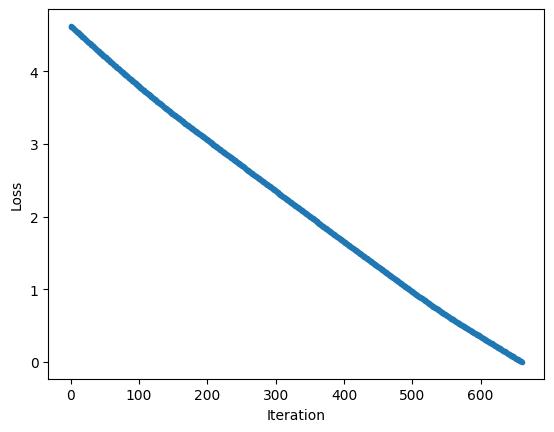

In [30]:
xopt, losses = min_hillclimb(
    lambda x: np.linalg.norm(x),
    [-4, .3, 2.3],
    1_000_000, 0.01, print_each=100, quiet=False
)
print(f"\nOptimum:\n\tx   ={xopt}\n\tf(x)={losses[-1]}")
plt.plot(losses, '.'); plt.xlabel('Iteration'); plt.ylabel('Loss');

## Hill climbing for Student regression

function_evaluations=  79985, loss=0.7440
function_evaluations= 159985, loss=0.7432
function_evaluations= 239985, loss=0.7420
function_evaluations= 319985, loss=0.7394
function_evaluations= 399985, loss=0.7367
function_evaluations= 479985, loss=0.7317
function_evaluations= 559985, loss=0.7198
function_evaluations= 639985, loss=0.6656
function_evaluations= 669745, loss=0.5758 all 16 neighbors rejected, giving up...
function_evaluations= 669745, loss=0.5758
shape: (8, 2)
┌───────────┬───────────┐
│ names     ┆ values    │
│ ---       ┆ ---       │
│ str       ┆ f64       │
╞═══════════╪═══════════╡
│ bias      ┆ 15.418927 │
│ area      ┆ -0.125    │
│ bedrooms  ┆ 0.085     │
│ bathrooms ┆ 0.305     │
│ mainroad  ┆ 0.32      │
│ basement  ┆ 0.12      │
│ scale     ┆ 0.27      │
│ nu        ┆ 2.4       │
└───────────┴───────────┘


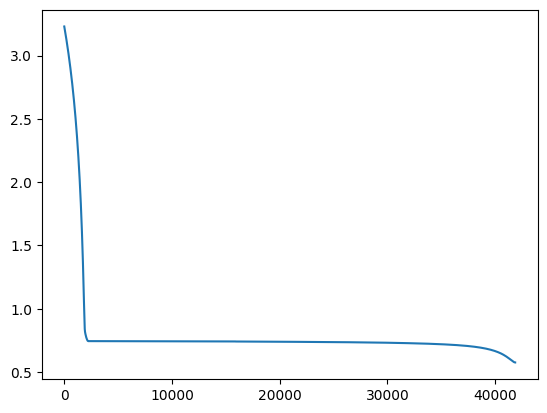

In [31]:
params_opt_hillclimb, losses_hillclimb = min_hillclimb(
    lambda par: nll_Student_penalized(par, X, y, 100),
    [
        1 + y.mean(), # bias
        *([0] * len(FEATURE_NAMES)), # weights
        10, # scale
        200, # nu
    ],
    1_000_000, 0.005, quiet=False
)
print(pl.DataFrame({
    'names': ['bias', *FEATURE_NAMES, 'scale', 'nu'],
    'values': params_opt_hillclimb
}))
plt.plot(losses_hillclimb);

# Minimization via simulated annealing

Available moves:
$$
\mathcal M = \{\alpha, -\alpha, 2\alpha, -2\alpha, 4\alpha, -4\alpha\}
$$

1. Given current parameter vector $\theta_k$.
2. Sample proposal (neighbor) $\tilde\theta_{k+1}$ by sampling a move for each dimension: $$
\begin{aligned}
\tilde\theta_{k+1,1} &= \theta_{k,1} + \mathrm{rnd}(\mathcal M)\\
\tilde\theta_{k+1,2} &= \theta_{k,2} + \mathrm{rnd}(\mathcal M)\\
\vdots&\\
\tilde\theta_{k+1,d} &= \theta_{k,d} + \mathrm{rnd}(\mathcal M)
\end{aligned}
$$Here we decided to sample a _much_ richer set of neighbors than for hill-climbing.
3. Accept or reject based on $f(\tilde\theta_{k+1})$ and $f(\theta_k)$.

In [32]:
moves = np.array([
    sign * mul * 0.1
    for sign in [-1,1] for mul in (1,2,4,8)
] + [0])
np.random.choice(moves, 10)

array([-0.8, -0.1,  0.2,  0.1,  0.8,  0. , -0.4, -0.4, -0.1, -0.1])

In [33]:
def min_anneal(f, x, maxfev: int, step_size: float=0.01, T: float=10, quiet=True):
    x = np.array(x)
    fx = f(x)
    best_x, best_fx = x.copy(), fx
    
    function_evaluations = 1
    moves1d = np.array([
        sign * mul * step_size
        for sign in [-1,1] for mul in (1,2,4,8)
    ] + [0])
    loss_history = [fx]
    while True:
        # Explore the Boltzmann distribution
        nsamples = 500
        naccepted = 0
        for _ in range(nsamples):
            # Each dimension gets its own random move!
            neighbor = x + np.random.choice(moves1d, len(x))
            f_neighbor = f(neighbor)
            function_evaluations += 1
            
            # Decide whether to accept
            df = f_neighbor - fx
            accept = False
            if df < 0:
                # Always accept if f(neighbor) < f(x)
                ...
            else: # df >= 0
                # If f(neighbor) > f(x), randomly accept anyway!
                accept = ...
            
            if accept:
                x[:], fx = neighbor, f_neighbor
                if fx < best_fx:
                    best_x[:], best_fx = x, fx

            naccepted += accept
            if function_evaluations >= maxfev:
                break # out of the inner loop
        # Make Boltzmann distribution more concentrated around minimizers
        T *= 0.99 # cool down, reduce temperature

        loss_history.append(fx)
        acceptance_probability = naccepted/nsamples
        if not quiet:
            print(f"{function_evaluations=:>7d} {T=:.6f} {fx=:+.5f} P(acc)={acceptance_probability:.3f}")
        if acceptance_probability < 0.01:
            print(f"{function_evaluations=:>7d} {T=:.6f} {fx=:+.5f} too many ({nsamples-naccepted}/{nsamples}) neighbors rejected, giving up...")
            break # out of the main loop
        if function_evaluations >= maxfev:
            break
    return best_x, np.array(loss_history + [best_fx])

In [34]:
xopt, losses = min_anneal(
    lambda x: x[0]**2 + 0.2*x[1]**2 + np.sin(10 * x[0] * x[1]),
    [-2., 6.], 1_000_000, T=10, quiet=False
)
xopt, losses[-1]

function_evaluations=    501 T=9.900000 fx=+6.04314 P(acc)=0.956
function_evaluations=   1001 T=9.801000 fx=+6.42785 P(acc)=0.946
function_evaluations=   1501 T=9.702990 fx=+3.40180 P(acc)=0.970
function_evaluations=   2001 T=9.605960 fx=+3.05163 P(acc)=0.972
function_evaluations=   2501 T=9.509900 fx=+5.37701 P(acc)=0.960
function_evaluations=   3001 T=9.414801 fx=+6.18673 P(acc)=0.972
function_evaluations=   3501 T=9.320653 fx=+8.65334 P(acc)=0.970
function_evaluations=   4001 T=9.227447 fx=+21.59331 P(acc)=0.952
function_evaluations=   4501 T=9.135172 fx=+26.04947 P(acc)=0.940
function_evaluations=   5001 T=9.043821 fx=+27.81719 P(acc)=0.958
function_evaluations=   5501 T=8.953383 fx=+27.30338 P(acc)=0.958
function_evaluations=   6001 T=8.863849 fx=+17.62942 P(acc)=0.952
function_evaluations=   6501 T=8.775210 fx=+20.88226 P(acc)=0.958
function_evaluations=   7001 T=8.687458 fx=+32.58338 P(acc)=0.946
function_evaluations=   7501 T=8.600584 fx=+20.76219 P(acc)=0.960
function_evaluati

(array([-0.26,  0.57]), np.float64(-0.863480195904649))

In [35]:
xopt, losses = min_anneal(
    lambda x: x[0]**2 + 0.2*x[1]**2 + np.sin(10 * x[0] * x[1]),
    [-2., 6.], 1000_000, T=10
)
xopt, losses[-1]

function_evaluations= 577001 T=0.000092 fx=-0.86348 too many (496/500) neighbors rejected, giving up...


(array([-0.26,  0.57]), np.float64(-0.8634801959046488))

In [37]:
xopt, losses = min_coord(
    lambda x: x[0]**2 + 0.2*x[1]**2 + np.sin(10 * x[0] * x[1]),
    [-2., 6.], 1000_000,
)
xopt, losses[-1]

function_evaluations=  44000 No more improvements possible


(array([ 0.24, -0.61]), np.float64(-0.8622826904151742))

# Newton-type methods

1. Gradient descent update:$$
\theta_{k+1} = \theta_k -\alpha \nabla f(\theta_k)
$$
2. Newton update: $$
\theta_{k+1} = \theta_k -\alpha H_k^{-1}\nabla f(\theta_k)
$$

- $\nabla f(\theta_k)$ is the gradient of $f$ evaluated at the point $\theta_k$.
- $H_k = \nabla^2 f(\theta_k)$ is the Hessian of $f$ evaluated at the point $\theta_k$.
- $\alpha > 0$ is the learning rate (step size).

Notes:
1. All proposals are always accepted.
2. This simple version is for _unconstrained_ optimization only! Can and will violate constraints like `x[0] > 0`.

### Silver bullet: `scipy.optimize.minimize`

Just use this for minimization.
- Examples: https://docs.scipy.org/doc/scipy/tutorial/optimize.html#local-minimization-of-multivariate-scalar-functions-minimize.
- API reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize.

In [38]:
from scipy.optimize import minimize

In [39]:
def myfn(xs: np.ndarray):
    x = xs[0]
    return x**2 + 3*x

minimize(myfn, [-2.], method='L-BFGS-B')

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -2.2499999999999996
        x: [-1.500e+00]
      nit: 2
      jac: [ 0.000e+00]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -1.3160432169893683
        x: [-5.215e-01  1.399e+00]
      nit: 7
      jac: [ 9.392e-06 -5.418e-06]
     nfev: 24
     njev: 8
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.3701875576241458
        x: [-1.652e+00 -6.324e+00]
      nit: 8
      jac: [ 1.177e-06  1.332e-07]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.053789956007031625
        x: [ 1.367e+00  7.784e+00]
      nit: 9
      jac: [-8.660e-07 -2.665e-07]
     nfev: 39
     njev: 13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


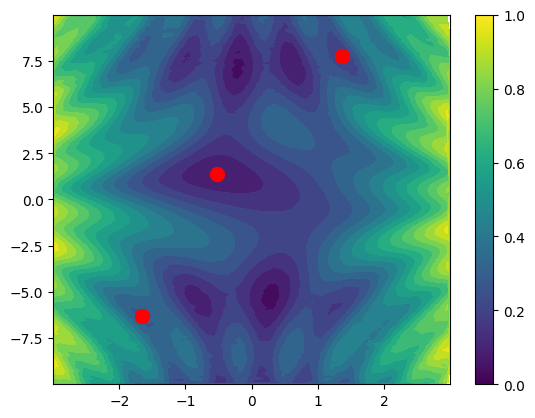

In [40]:
def myfn(xs: np.ndarray):
    x, y = xs
    return x**2 + np.sin(x * y) - np.cos(y - 1)

sol1 = minimize(myfn, [-2., 1.5], method='L-BFGS-B')
sol2 = minimize(myfn, [-2., -5], method='L-BFGS-B')
sol3 = minimize(myfn, [2., 5], method='L-BFGS-B')
print(sol1); print()
print(sol2); print()
print(sol3)

points = np.hstack([
    np.random.uniform(-3,3, (10_000, 1)),
    np.random.uniform(-10, 10, (10_000, 1))
])
plt.tricontourf(points[:, 0], points[:, 1], [myfn(point) for point in points], levels=20)
plt.scatter([sol1.x[0], sol2.x[0], sol3.x[0]], [sol1.x[1], sol2.x[1], sol3.x[1]], c='red', s=100)
plt.colorbar();

## Modifying Student loss to be unconstrained

Basic gradient descent cannot handle constraints!

Need to make our objective function unconstrained.

Our constraints for Student $f(b,w,\sigma,\nu) = -\frac1N \sum_{n=1}^N \ln p(y_n; b + w^\top x_n, \sigma, \nu)$:
$$
\begin{aligned}
\sigma &>0\\ \nu &> 0
\end{aligned}
$$

Introduce new unconstrained variables:
$$
\begin{aligned}
u_\sigma &= \ln\sigma \in \mathbb R\\
u_\nu &= \ln\nu \in \mathbb R
\end{aligned}
$$

New objective (negative log-likelihood) in terms of these _unconstrained_ parameters $(b,w,u_\sigma,u_\nu) \in \mathbb R^{1+F+1+1}$:
$$
\begin{split}
f(b,w, u_\sigma, u_\nu) &=
-\sum_{n=1}^N \ln \left[
 \frac{1}{\exp u_\sigma} p\left(
     \frac{y_n - b - x_n^\top w}{\exp u_\sigma}; \exp u_\nu
 \right)
\right] + \lambda \frac12 \lVert w \rVert^2
\end{split}
$$

In [41]:
def to_unconstrained(params: np.ndarray):
    stuff, sigma, nu = params[:-2], params[-2], params[-1]
    return np.array([*stuff, np.log(sigma), np.log(nu)])

def from_unconstrained(params: np.ndarray):
    stuff, usigma, unu = params[:-2], params[-2], params[-1]
    return np.array([*stuff, np.exp(usigma), np.exp(unu)])

In [42]:
def logpdf_Student_unconstrained(x, mu, usigma, unu):
    sigma, nu = np.exp(usigma), np.exp(unu)
    t = (x - mu)/sigma
    return (
        -usigma - unu / 2 - np.log(beta(1/2, nu/2))
        -(nu+1)/2 * np.log(1 + t**2 / nu)
    )

def loglik_Student_unconstrained(params: np.ndarray, X, y):
    N, F = X.shape
    b, w, usigma, unu = params[0], params[1:F+1], params[F+1], params[-1]
    # Now there are NO constraints!
    # if (sigma <= 0) or (nu <= 0):
    #     return -np.inf # Constraints are violated!!

    location = b + X @ w
    return logpdf_Student_unconstrained(y, location, usigma, unu).sum()

def nll_Student_penalized_unconstrained(params: np.ndarray, X, y, lmb=0.0):
    "Estimates -E(log p(y_n | x_n, params))"
    N, F = X.shape
    b, w, usigma, unu = params[0], params[1:F+1], params[F+1], params[-1]
    nll = -loglik_Student_unconstrained(params, X, y) + lmb/2 * np.linalg.norm(w)**2
    return nll / N

In [43]:
nll_Student_penalized_unconstrained(
    np.array([
        y.mean(), # bias
        0.1,0,0,0,0, # weights
        np.log(10), # scale
        np.log(200), # nu
    ]), X, y
)

np.float64(3.2277227021651274)

In [44]:
solution = minimize(
    lambda par: nll_Student_penalized_unconstrained(par, X, y, 100.0),
    np.array([
        y.mean(), # bias
        0.1,0,0,0,0, # weights
        np.log(10), # scale
        np.log(200), # nu
    ]), method='L-BFGS-B'
)
print(f'Best loss: {solution.fun:.6f}')
print(pl.DataFrame({
    'names': ['bias', *FEATURE_NAMES, 'scale', 'nu'],
    'values': from_unconstrained(solution.x)
}))

Best loss: 0.368539
shape: (8, 2)
┌───────────┬───────────┐
│ names     ┆ values    │
│ ---       ┆ ---       │
│ str       ┆ f64       │
╞═══════════╪═══════════╡
│ bias      ┆ 11.535473 │
│ area      ┆ 0.358351  │
│ bedrooms  ┆ 0.082906  │
│ bathrooms ┆ 0.238211  │
│ mainroad  ┆ 0.186928  │
│ basement  ┆ 0.10878   │
│ scale     ┆ 0.196826  │
│ nu        ┆ 1.959055  │
└───────────┴───────────┘


# Full implementation of Student regression

In [45]:
from typing import Literal

class RidgeStudent:
    def __init__(
        self, lmb: float, feature_names: list[str],
        method: Literal['coord', 'anneal', 'hillclimb']='L-BFGS-B',
        unconstrained=True,
        step_size: float=0.005, maxfev: int=1_000_000, quiet=True
    ):
        assert lmb >= 0
        assert step_size > 0
        assert maxfev > 0
        self.lmb = lmb
        self.feature_names = list(feature_names)
        self.unconstrained = unconstrained
        self.step_size, self.maxfev = step_size, maxfev
        self.method, self.quiet = method, quiet

    @property
    def params_df(self) -> pl.DataFrame: return pl.DataFrame({
        'name': ['bias', *self.feature_names, 'scale', 'nu'],
        'value': [self.intercept_, *self.coef_, self.scale_, self.nu_]
    })

    def __repr__(self):
        AIC, BIC = self.aic_, self.bic_
        with pl.Config(tbl_hide_column_data_types=True):
            return (
                f"{self.__class__.__name__}({self.lmb}) ({AIC=:.3f}, {BIC=:.3f}, method={self.method}):\n"
                f"{self.params_df}"
            )

    def fit(self, X, y):
        N, F = X.shape
        params = [
            y.mean(), # bias
            *np.full(F, 1e-3), # weights
            y.std(), # scale
            200, # nu
        ]
        optimizers_custom = {
            'coord': min_coord,
            'anneal': min_anneal,
            'hillclimb': min_hillclimb
        }
        if self.unconstrained:
            loss = lambda par: nll_Student_penalized_unconstrained(par, X, y, self.lmb)
        else:
            loss = lambda par: nll_Student_penalized(par, X, y, self.lmb)
            
        if self.method not in optimizers_custom:
            solution = minimize(loss, to_unconstrained(params), method=self.method)
            params_opt = from_unconstrained(solution.x)
        else:
            optimizer = optimizers_custom[self.method]
            if self.unconstrained:
                params = to_unconstrained(params)
            params_opt, _ = optimizer(
                loss, params, self.maxfev, self.step_size, quiet=self.quiet
            )
            if self.unconstrained:
                params_opt = from_unconstrained(params_opt)
        
        self.intercept_, self.coef_, self.scale_, self.nu_ = (
            params_opt[0], params_opt[1:F+1], params_opt[F+1], params_opt[-1]
        )
        self.residuals_ = (y - self.intercept_ - X @ self.coef_) / self.scale_
        loglik = loglik_Student(params_opt, X, y)
        self.aic_ = aic(loglik, len(params_opt))
        self.bic_ = bic(loglik, len(params_opt), N)
        return self

In [46]:
%time RidgeGauss(10, FEATURE_NAMES).fit(X, y)

CPU times: user 2.59 ms, sys: 910 μs, total: 3.5 ms
Wall time: 2.73 ms


RidgeGauss(10) (AIC=699.814, BIC=729.920):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 11.246463 │
│ area      ┆ 0.412755  │
│ bedrooms  ┆ 0.06782   │
│ bathrooms ┆ 0.212464  │
│ mainroad  ┆ 0.164285  │
│ basement  ┆ 0.106734  │
│ scale     ┆ 0.453958  │
│ nu        ┆ inf       │
└───────────┴───────────┘

In [47]:
%time RidgeStudent(10, FEATURE_NAMES, 'coord', unconstrained=True, quiet=False).fit(X, y)

function_evaluations=      0 BEGIN
	function_evaluations=   4000 dim= 0 fx=0.78779 
	function_evaluations=   8000 dim= 1 fx=0.78773 !
	function_evaluations=  12000 dim= 2 fx=0.78709 !
	function_evaluations=  16000 dim= 3 fx=0.78561 !
	function_evaluations=  20000 dim= 4 fx=0.78550 !
	function_evaluations=  24000 dim= 5 fx=0.78357 !
	function_evaluations=  28000 dim= 6 fx=0.78334 !
	function_evaluations=  32000 dim= 7 fx=0.76553 !
function_evaluations=  32000 END fx=0.76553
function_evaluations=  32000 BEGIN
	function_evaluations=  36000 dim= 0 fx=0.76553 
	function_evaluations=  40000 dim= 1 fx=0.75031 !
	function_evaluations=  44000 dim= 2 fx=0.75031 
	function_evaluations=  48000 dim= 3 fx=0.74757 !
	function_evaluations=  52000 dim= 4 fx=0.74749 !
	function_evaluations=  56000 dim= 5 fx=0.74721 !
	function_evaluations=  60000 dim= 6 fx=0.72371 !
	function_evaluations=  64000 dim= 7 fx=0.70998 !
function_evaluations=  64000 END fx=0.70998
function_evaluations=  64000 BEGIN
	function_

RidgeStudent(10) (AIC=622.185, BIC=656.591, method=coord):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 15.393927 │
│ area      ┆ -0.1      │
│ bedrooms  ┆ 0.055     │
│ bathrooms ┆ 0.275     │
│ mainroad  ┆ 0.27      │
│ basement  ┆ 0.11      │
│ scale     ┆ 0.273898  │
│ nu        ┆ 2.471932  │
└───────────┴───────────┘

In [48]:
%time RidgeStudent(10, FEATURE_NAMES, 'anneal', unconstrained=True).fit(X, y)

function_evaluations= 452001 T=0.001133 fx=+0.35050 too many (498/500) neighbors rejected, giving up...
CPU times: user 7 s, sys: 18.4 ms, total: 7.02 s
Wall time: 7.02 s


RidgeStudent(10) (AIC=393.113, BIC=427.520, method=anneal):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 11.163927 │
│ area      ┆ 0.401     │
│ bedrooms  ┆ 0.081     │
│ bathrooms ┆ 0.251     │
│ mainroad  ┆ 0.186     │
│ basement  ┆ 0.111     │
│ scale     ┆ 0.195452  │
│ nu        ┆ 1.93154   │
└───────────┴───────────┘

In [49]:
%time RidgeStudent(10, FEATURE_NAMES, 'hillclimb', unconstrained=True).fit(X, y)

function_evaluations=  22401, loss=0.4863 all 16 neighbors rejected, giving up...
CPU times: user 233 ms, sys: 1.04 ms, total: 234 ms
Wall time: 233 ms


RidgeStudent(10) (AIC=544.009, BIC=578.416, method=hillclimb):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 14.503927 │
│ area      ┆ -0.009    │
│ bedrooms  ┆ 0.066     │
│ bathrooms ┆ 0.306     │
│ mainroad  ┆ 0.306     │
│ basement  ┆ 0.121     │
│ scale     ┆ 0.241125  │
│ nu        ┆ 2.210718  │
└───────────┴───────────┘

In [50]:
%time RidgeStudent(10, FEATURE_NAMES, 'L-BFGS-B').fit(X, y)

CPU times: user 14 ms, sys: 875 μs, total: 14.9 ms
Wall time: 14.3 ms


RidgeStudent(10) (AIC=392.604, BIC=427.011, method=L-BFGS-B):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 11.344411 │
│ area      ┆ 0.379847  │
│ bedrooms  ┆ 0.080232  │
│ bathrooms ┆ 0.246966  │
│ mainroad  ┆ 0.192996  │
│ basement  ┆ 0.112201  │
│ scale     ┆ 0.196861  │
│ nu        ┆ 1.963466  │
└───────────┴───────────┘

In [51]:
model_Gauss = RidgeGauss(10, FEATURE_NAMES).fit(X, y)
model_Student = RidgeStudent(10, FEATURE_NAMES, 'L-BFGS-B').fit(X, y)

In [52]:
model_Gauss.params_df.join(model_Student.params_df, on='name', suffix='_Student')

name,value,value_Student
str,f64,f64
"""bias""",11.246463,11.344411
"""area""",0.412755,0.379847
"""bedrooms""",0.06782,0.080232
"""bathrooms""",0.212464,0.246966
"""mainroad""",0.164285,0.192996
"""basement""",0.106734,0.112201
"""scale""",0.453958,0.196861
"""nu""",inf,1.963466


Note that $\nu\approx 2$, so the corresponding Student distribution is far away from Gaussian (when $\nu\to\infty$).

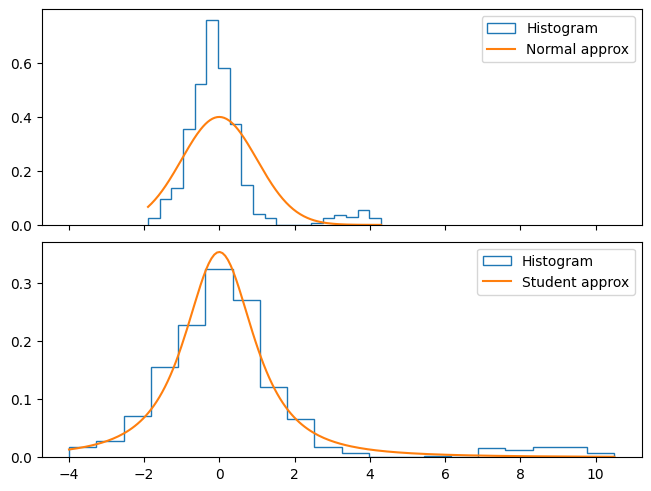

In [53]:
noise_Gauss = model_Gauss.residuals_
noise_Student = model_Student.residuals_

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, layout='constrained')
ax1.hist(noise_Gauss, bins=20, histtype='step', density=True, label="Histogram")
possible_noises = np.linspace(noise_Gauss.min(), noise_Gauss.max(), 200)
ax1.plot(possible_noises, pdf_Gauss(possible_noises, 0, 1), label="Normal approx")
ax1.legend()

ax2.hist(noise_Student, bins=20, histtype='step', density=True, label="Histogram")
possible_noises = np.linspace(noise_Student.min(), noise_Student.max(), 200)
ax2.plot(possible_noises, pdf_Student(possible_noises, 0, 1, model_Student.nu_), label="Student approx")
ax2.legend()
fig;